Exercise is meant for you to experiment with cython and numba to see how much efficiency can be obtained by using these two tools

In [1]:
import numpy as np
import seaborn as sb
import pandas as pd

In [2]:
class Particle:
  def __init__(self, x, y, ang_speed):
    self.x = x
    self.y = y
    self.ang_speed = ang_speed

In [3]:
def evolve_wrapper(dt, particles):
  timestep = 1
  nsteps = int(dt/timestep)
  r_i = np.array([[p.x, p.y] for p in particles])
  ang_speed = np.array([p.ang_speed for p in particles])
  evolve(r_i, ang_speed, timestep, nsteps)

  for i, p in enumerate(particles):
    p.x, p.y = r_i[i]

def evolve(r_i, ang_speed, timestep, nsteps):
  v_i = np.empty_like(r_i)
  for i in range(nsteps):
    norm_i = np.sqrt((r_i ** 2).sum(axis=1))
    v_i = r_i[:, [1,0]]
    v_i[:, 0] *= -1
    v_i /= norm_i[:, np.newaxis]
    d_i = timestep * ang_speed[:, np.newaxis] * v_i

    r_i += d_i

In [4]:
n_particle = 100
coord = np.random.randn(n_particle, 3)
particles = []
for i in range(0, n_particle):
  particles.append(Particle(coord[i][0], coord[i][1], coord[i][2]))

<AxesSubplot:xlabel='x', ylabel='y'>

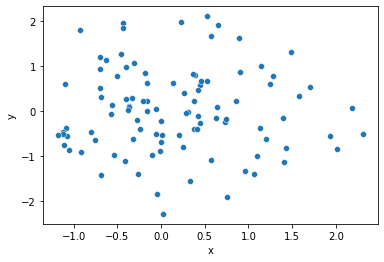

In [5]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [6]:
evolve_wrapper(1, particles)

<AxesSubplot:xlabel='x', ylabel='y'>

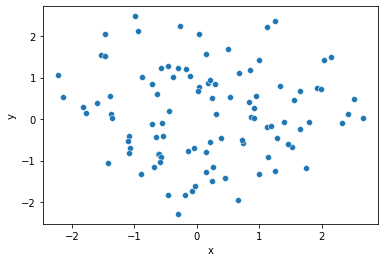

In [7]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [8]:
%timeit evolve_wrapper(1, particles)

161 µs ± 6.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Can you rewrite the evolve method to make it faster?